## Milestone 3: Multi-task training

We are going to leverage other subreddits data to help the model to learn the domain of `Reddit`. The other additional data will be used for the task of "Title generation". 

1. Generate title generation train/val set with 'prefix','input_text' and 'target_text' columns

In [10]:
import pandas as pd

In [43]:
## Summarize Title
title_df = pd.read_csv('competitors_reddit.csv')
title_df.head()

,index,submission_id,submission_title,submission_link_flair_text,submission_selftext,reply_body
0,0,f96vya,New versions of A5 and A6 Agile firmwares are ...,NaN,"Dear Supernote users, new versions of A5 and A...","[""There was video of a multifunction button to..."
1,1,f9dsst,Feature request. Pressure sensitivity.,NaN,Thank you for the new firmware update. It adds...,['We are happy that you can enjoy this firmwar...
2,2,fp66n4,Quick Guide — Set Up and Connect to the Supern...,NaN,Set up and connect to the Supernote Cloud acco...,"[""What I would like to know is where can one b..."
3,3,fs454n,How to use handwriting to text function?,NaN,How do you achieve this? I've not been able to...,"['Currently you can try the ""Smart Writing"" fu..."
4,4,fs46fj,Email inbox issues,NaN,"I have set up my email, and can send emails. M...","[""Hi aubrit512,\n\nPlease try to update the sy..."


In [44]:
for idx, row in title_df.iterrows():
    all_text = ''
    if type(row.submission_selftext)==str:
        all_text += row.submission_selftext
    if type(row.reply_body) ==list:
        all_text += ' '.join(row.reply_body[:3]) # Include first 5 replies
    
    title_df.loc[idx,'all_text'] = all_text

In [45]:
# Remove rows with no title
title_df = title_df[title_df.all_text.str.len()>0]

In [46]:
title_df["prefix"] = "title prediction"
title_df = title_df.rename({'all_text':'input_text',
                 'submission_title':'target_text'},
               axis=1)
title_df = title_df[['prefix','input_text', 'target_text']]                 

In [47]:
title_df.head()

,prefix,input_text,target_text
0,title prediction,"Dear Supernote users, new versions of A5 and A...",New versions of A5 and A6 Agile firmwares are ...
1,title prediction,Thank you for the new firmware update. It adds...,Feature request. Pressure sensitivity.
2,title prediction,Set up and connect to the Supernote Cloud acco...,Quick Guide — Set Up and Connect to the Supern...
3,title prediction,How do you achieve this? I've not been able to...,How to use handwriting to text function?
4,title prediction,"I have set up my email, and can send emails. M...",Email inbox issues


2. Split into val_title_df and train_title_df with 10% for val

In [48]:
val_title_df = title_df.sample(frac=0.1,random_state=42)
train_title_df = title_df[~title_df.index.isin(val_title_df.index)]

In [49]:
train_tag_df = pd.read_csv("singletask_train.csv").astype(str)
val_tag_df = pd.read_csv("singletask_noupsampling_val.csv").astype(str)

In [50]:
combined_train_df = pd.concat([train_title_df,train_tag_df],axis=0)
combined_val_df = pd.concat([val_title_df,val_tag_df],axis=0)
combined_train_df.head()

,prefix,input_text,target_text
0,title prediction,"Dear Supernote users, new versions of A5 and A...",New versions of A5 and A6 Agile firmwares are ...
1,title prediction,Thank you for the new firmware update. It adds...,Feature request. Pressure sensitivity.
2,title prediction,Set up and connect to the Supernote Cloud acco...,Quick Guide — Set Up and Connect to the Supern...
3,title prediction,How do you achieve this? I've not been able to...,How to use handwriting to text function?
4,title prediction,"I have set up my email, and can send emails. M...",Email inbox issues


## Model Training

In [51]:
import wandb
from simpletransformers.t5 import T5Model

In [52]:
model_args = {
    "output_dir": './multitask', #specify output directory
    "max_seq_length": 400,
    "train_batch_size": 2,
    "eval_batch_size": 2,
    "num_train_epochs": 4,
    "evaluate_during_training": True,
    #"evaluate_during_training_steps": 15000,
    "evaluate_during_training_verbose": True,
    "evaluate_each_epoch": True,
    "use_multiprocessing": False,
    "fp16": False,
    "save_steps": -1,
    "save_eval_checkpoints": False,
    "save_model_every_epoch": False,
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "wandb_project": "T5 - single task",
    "scheduler": "polynomial_decay_schedule_with_warmup"
}

In [53]:
model = T5Model("t5", "t5-small", args=model_args)
model.train_model(combined_train_df, eval_data=combined_val_df)
wandb.finish()

  0%|          | 0/1773 [00:00<?, ?it/s]

/home/winnie/miniconda3/envs/project3_env/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:3282: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  FutureWarning,


Using Adafactor for T5


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/887 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/887 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/887 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/887 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Training loss,0.01976
lr,1e-05
global_step,3548
_runtime,546
_timestamp,1626074569
_step,74
eval_loss,0.05793
train_loss,0.08134


Training loss,█▅▅▂▃▅▆▃▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,▃▄████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eval_loss,█▁▁▂▁
train_loss,█▁▂▂▁


##### Look at model performance

In [54]:
eval_df = pd.read_csv('singletask_noupsampling_val.csv')

In [55]:
model_args = {
    "overwrite_output_dir": True,
    "max_seq_length": 400,
    "eval_batch_size": 4,
    "use_multiprocessing": False,
    "num_beams": 5,
    "do_sample": True,
    "max_length": 10,
    "top_k": 10,
    "top_p": 0.95,
    "num_return_sequences": 2,
}

In [56]:
# Load the trained model
model = T5Model("t5","multitask", args=model_args)

In [57]:
# Prepare the data for testing
to_predict = [
    prefix + ": " + str(input_text)
    for prefix, input_text in zip(eval_df["prefix"].tolist(), eval_df["input_text"].tolist())
]
truth = eval_df["target_text"].tolist()
tasks = eval_df["prefix"].tolist()

# Get the model predictions
preds = model.predict(to_predict)

Generating outputs:   0%|          | 0/13 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/98 [00:00<?, ?it/s]

In [58]:
predicted_labels = []
for cur_pred in preds:
    cur_pred = cur_pred[0].strip()
    predicted_labels.append(cur_pred)

val_labels = eval_df['target_text']

In [59]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(val_labels, predicted_labels))

                 precision    recall  f1-score   support

       Question       0.90      1.00      0.95        37
         Review       1.00      0.67      0.80         3
Stylus problems       0.00      0.00      0.00         1
      Templates       1.00      0.75      0.86         8

       accuracy                           0.92        49
      macro avg       0.73      0.60      0.65        49
   weighted avg       0.91      0.92      0.91        49



/home/winnie/miniconda3/envs/project3_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/winnie/miniconda3/envs/project3_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/winnie/miniconda3/envs/project3_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

Text(33.0, 0.5, 'True')

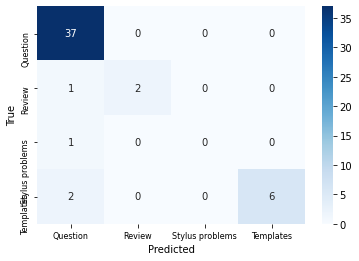

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(val_labels, predicted_labels)
fig = plt.figure()
ax = fig.add_subplot(111)
sns.heatmap(cm, annot=True, cmap='Blues')
labels=['Question','Review','Stylus problems','Templates']
ax.set_xticklabels(labels,fontsize=8)
ax.set_yticklabels(labels,fontsize=8)
plt.xlabel('Predicted')
plt.ylabel('True')

## Model Monitoring Using Wandb

<img src="../Images (if applicable)/M3_wandb.png" alt = "test pic" style = "width:1182px; height=702px;">

Both train and val loss are decreasing steadily over the course of training. We don't see any overfitting

## Conclusion
- Our model weighted F1-score improved from 0.85 to 0.91 after learning the representations from other subreddits. 